In [2]:
import matplotlib.pyplot as plt

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

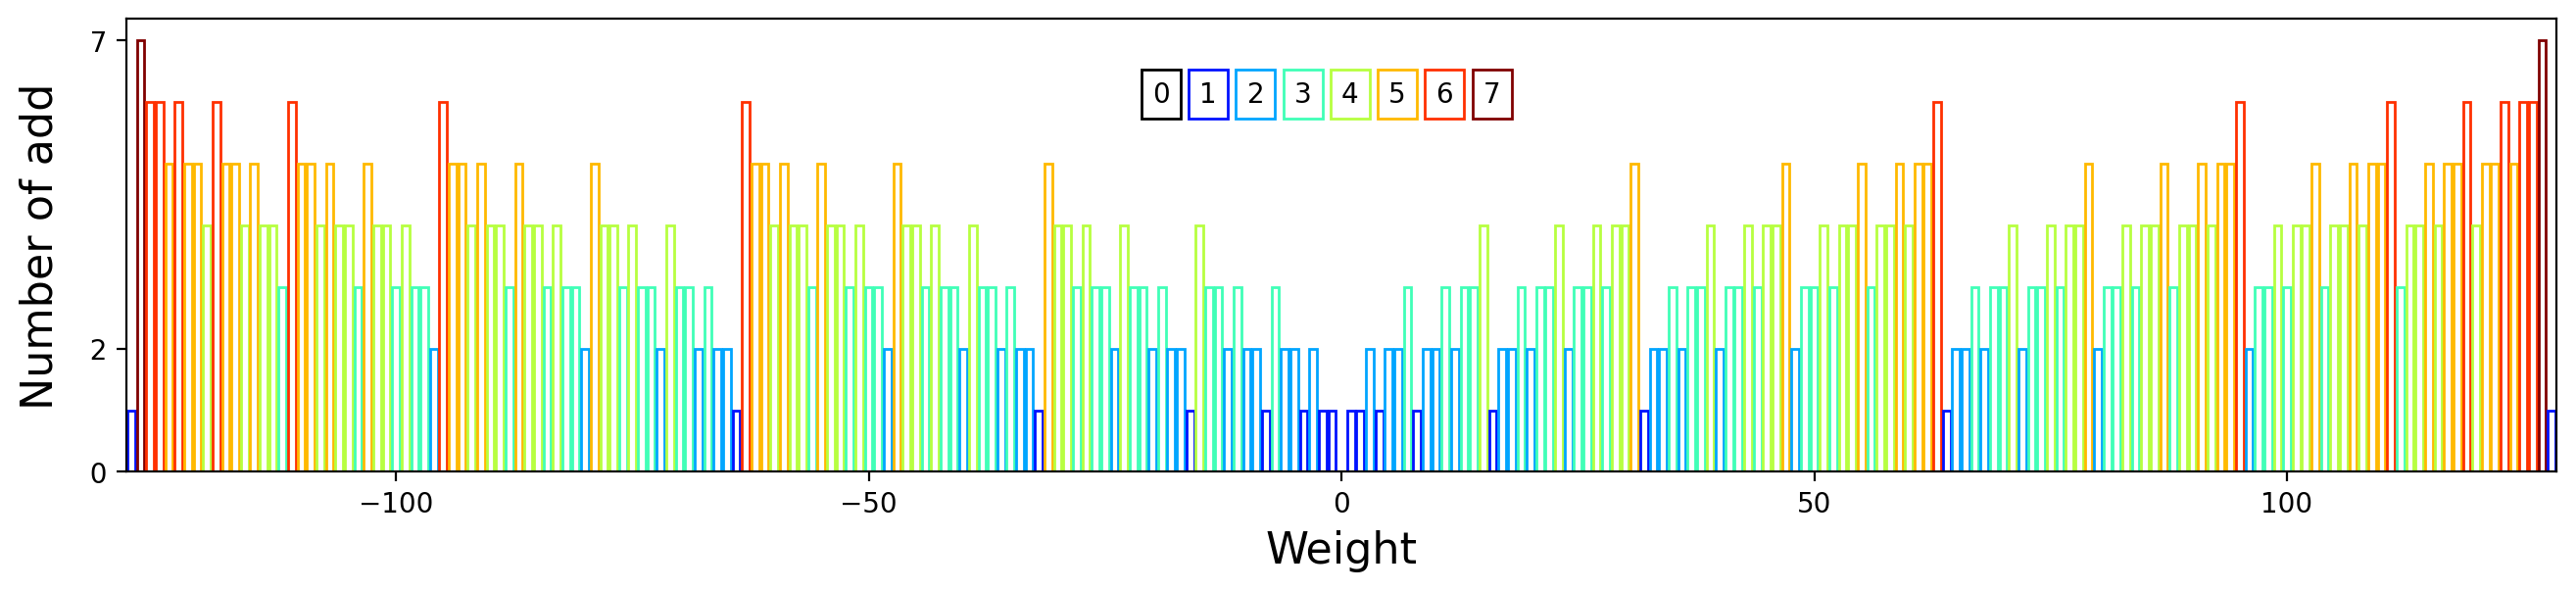

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
from core.layers.bconv2d import compute_bit_cost, bit2min, bit2max
import torch
import matplotlib.cm as cm
label_fontsize = 16


plt.figure(21, figsize=(16,3),dpi=200)
bit=8

scost, sdist = compute_bit_cost(bit)
x = torch.linspace(bit2min(bit), bit2max(bit),  2**bit+1).float()

cost_color = []
for i in range(len(scost)):
    cost_color.append(cm.jet((scost[i].item())/7.0))
    
    
plt.bar(x, scost, linewidth=1,fill=False, edgecolor=cost_color)

for c in range(8):
    if c==0:
        col = (0,0,0)
    else:
        col = cm.jet(c/7.0)
    # plt.text(-125+ (c)*16, 50, str(c))
    plt.text(-20+ (c)*5, 6, str(c), bbox=dict(edgecolor=col, facecolor='none'))
    
# plt.title('BitPrune cost')
plt.xlabel("Weight",fontsize=label_fontsize)
plt.ylabel("Number of add",fontsize=label_fontsize)
plt.xlim([-128.5,128.5])
plt.yticks([0, 2, 7],['  0', '  2','  7'])
# set_size(16,3)
# plt.legend(loc='upper left', fontsize=12)

plt.savefig((os.path.join('misc', 'cost_0.png')), bbox_inches='tight')
plt.savefig((os.path.join('misc', 'cost_0.pdf')), bbox_inches='tight')
plt.show()


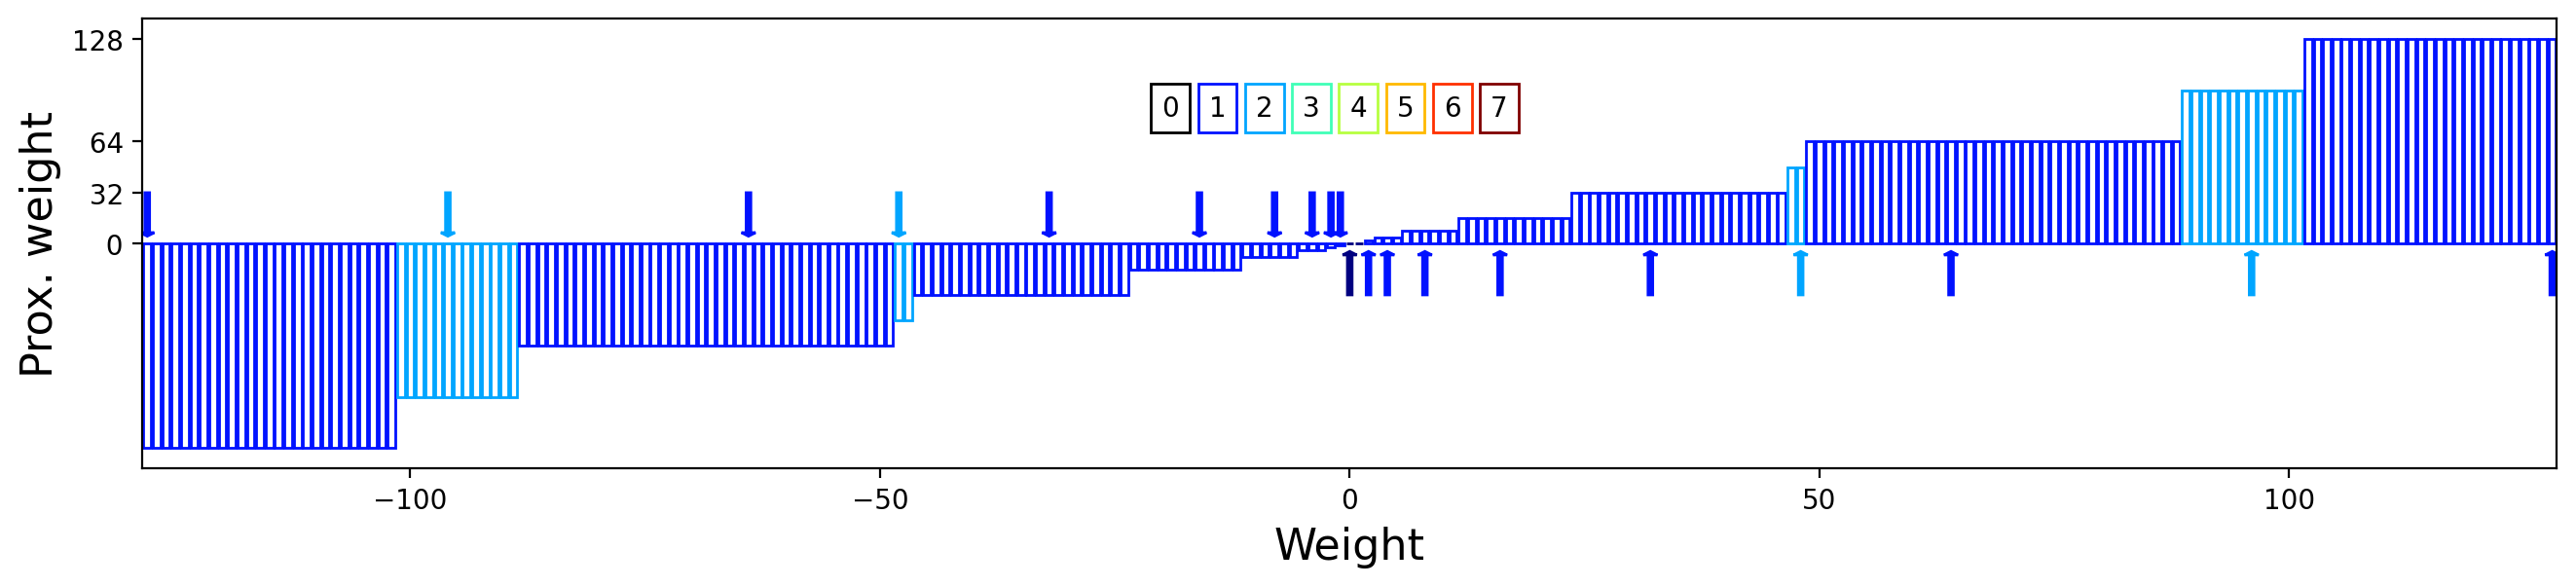

In [16]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
from core.layers.bconv2d import compute_bit_cost, compute_wgt_cost, bit2min, bit2max
import torch
import matplotlib.cm as cm

label_fontsize = 16


plt.figure(21, figsize=(16,3),dpi=200)
bit=8
pnorm = 0.5
lamda = 1.0

x = torch.linspace(bit2min(bit), bit2max(bit),  2**bit+1).float()


bit_cost, bit_cost_m = compute_bit_cost(bit)
wgt_cost, wgt_cost_m = compute_wgt_cost(bit, pnorm=0.5)

cost = lamda*bit_cost_m + wgt_cost_m
tgt_bin = cost.argmax(dim=1)

# print(tgt_bin)

tgt_bin_cost = bit_cost[tgt_bin]

cost_color = []
for i in range(len(tgt_bin)):
    cost_color.append(cm.jet((tgt_bin_cost[i].item())/7.0))

selected_w = []
for i in range(len(tgt_bin)):
    selected_w.append((x[tgt_bin[i]]))
    if i==tgt_bin[i]:
        plt.arrow(x[i], 32* (-1.0 if x[i]>=0 else 1.0), 0, 25* (-1.0 if x[i]<0 else 1.0) ,shape='full', color=cost_color[i], width=0.5)

for c in range(8):
    if c==0:
        col = (0,0,0)
    else:
        col = cm.jet(c/7.0)
    plt.text(-20+ (c)*5, 80, str(c), bbox=dict(edgecolor=col, facecolor='none'))
    
plt.bar(x, selected_w, linewidth=1, fill=False, edgecolor=cost_color)

# plt.title('bin connection cost')
plt.xlabel("Weight",fontsize=label_fontsize)
plt.ylabel("Prox. weight",fontsize=label_fontsize)
plt.xlim([-128.5, 128.5])
# plt.legend(loc='upper left', fontsize=16)

fname = os.path.join('misc', 'argmin_{:0.1f}{:0.1f}_.{}')
plt.yticks([0, 32, 64, 128], ['  0',' 32', ' 64','128'])
plt.savefig(fname.format(lamda, pnorm, 'pdf'), bbox_inches='tight')
plt.savefig(fname.format(lamda, pnorm, 'png'), bbox_inches='tight')
plt.show()


0.5
original


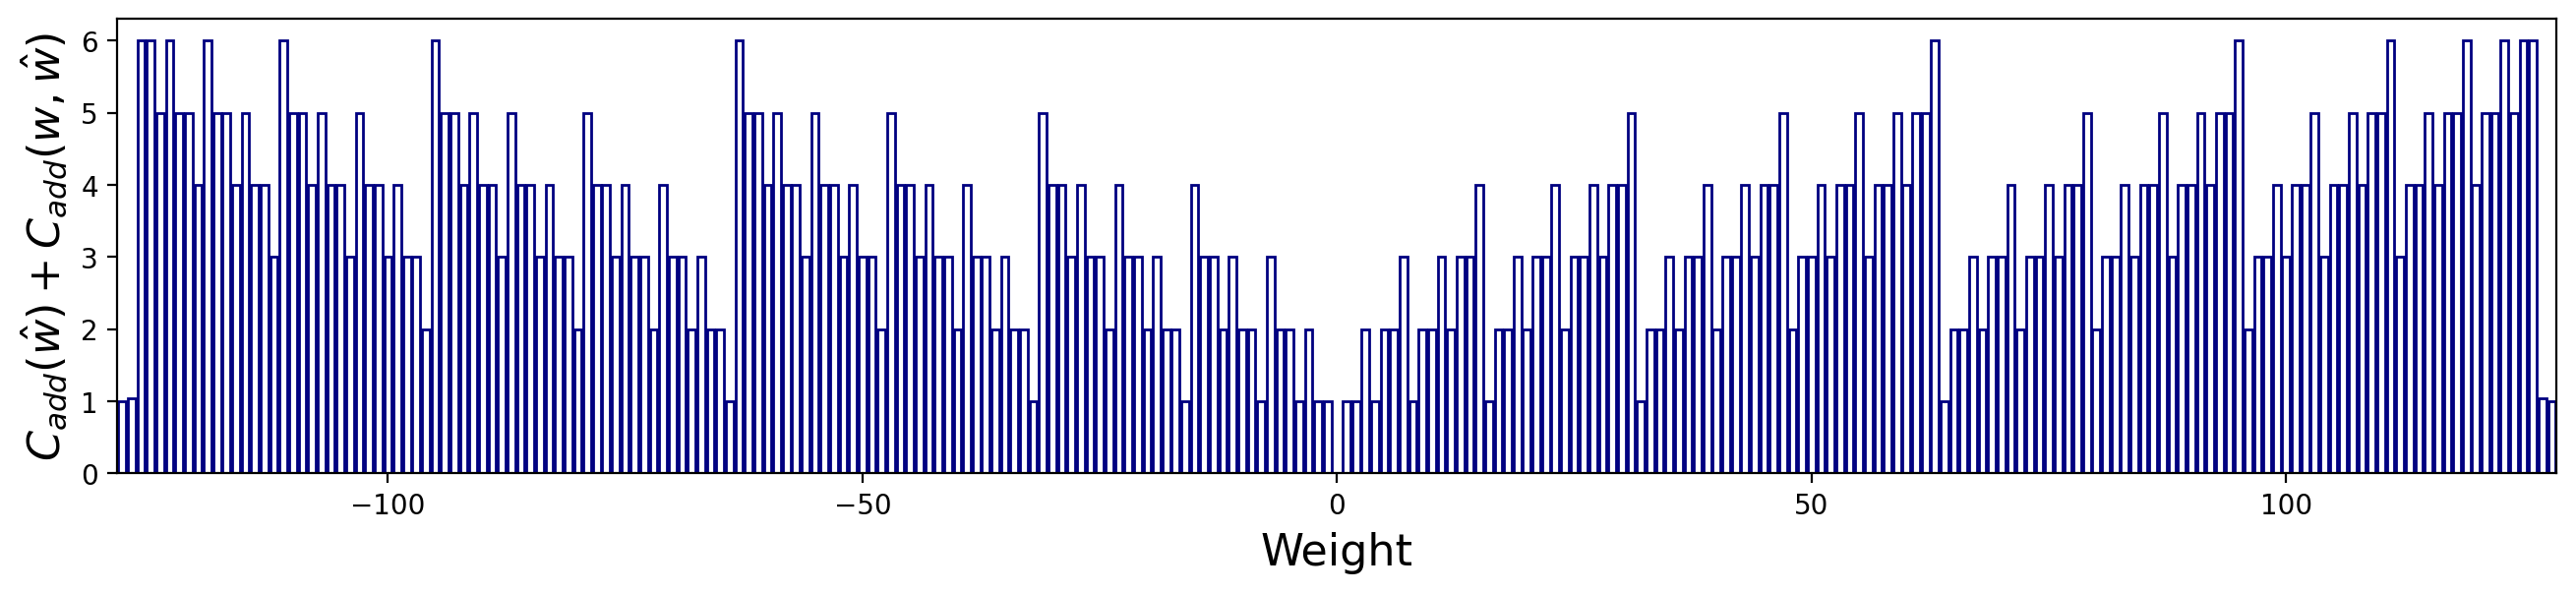

In [18]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
from core.layers.bconv2d import compute_bit_cost, compute_wgt_cost, bit2min, bit2max
import torch
import matplotlib.cm as cm

label_fontsize = 16

def compute_cost(bit, pnorm, lamda, mod=False):
    print(pnorm)
    bit_cost, bit_cost_m = compute_bit_cost(bit)
    wgt_cost, wgt_cost_m = compute_wgt_cost(bit, pnorm)

    cost = lamda*bit_cost_m + wgt_cost_m
    tgt_bin = cost.argmax(dim=1)

    # Copy target value's cost, and add the distance to the 
    wgt_cost_new = torch.zeros_like(wgt_cost)
    wgt_cost_new = -wgt_cost_m[range(len(wgt_cost_new)), tgt_bin]
    # print(wgt_cost_new)
    if mod==True:
        print('original')
        cost = bit_cost[tgt_bin]  + wgt_cost_new
    else:
        print('mod')
        cost = bit_cost[tgt_bin]  + wgt_cost_new + (bit_cost - bit_cost[tgt_bin])/16
    
    # print(wgt_cost_new)
    return cost


plt.figure(21, figsize=(16,3),dpi=200)
bit=8
pnorm = 0.5 # 0.5 1.0
lamda = 0.01
mod = True

cost = compute_cost(bit, pnorm, lamda, mod)

x = torch.linspace(bit2min(bit), bit2max(bit),  2**bit+1).float()
plt.bar(x, cost, linewidth=1,fill=False, edgecolor=cm.jet((1-2)/5.0))

# plt.title('bin connection cost')
plt.xlabel("Weight",fontsize=label_fontsize)
plt.ylabel("$C_{add}(\hat{w})+C_{add}(w, \hat{w})$", fontsize=label_fontsize)
plt.xlim([-128.5,128.5])
# plt.legend(loc='upper left', fontsize=16)

fname = os.path.join('misc', 'cost_{:0.1f}_{:0.1f}_{}.{}')
plt.savefig(fname.format(lamda,pnorm,~mod, 'pdf'), bbox_inches='tight')
plt.savefig(fname.format(lamda,pnorm,~mod, 'png'))
plt.show()


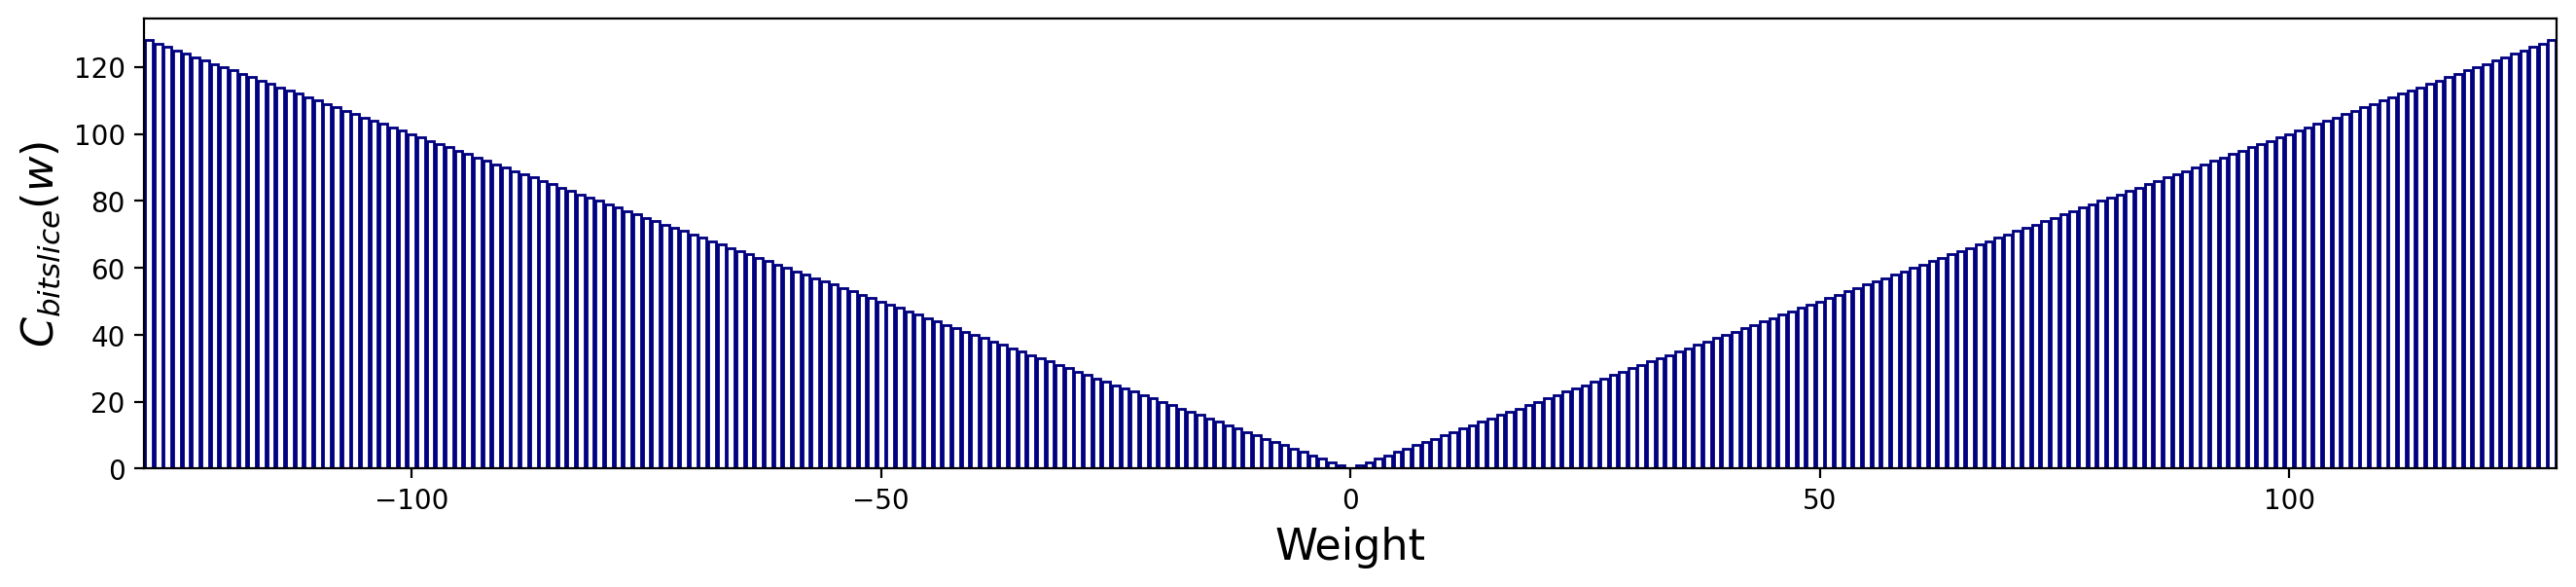

In [20]:
# Visualize loss landscape of the bit-slice loss function
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# calc_l1_and_zero_ratio

import matplotlib.pyplot as plt
import os
from core.layers.bconv2d import compute_bit_cost, compute_wgt_cost, bit2min, bit2max, binary
import torch
import matplotlib.cm as cm

label_fontsize = 16

def compute_cost(bit, n_pair):
    cost = []
    x = torch.linspace(bit2min(bit), bit2max(bit),  2**bit+1).float()
    
    if n_pair==1:
        for v_ in x:
            cost_ = 0
            tmp = binary((v_.abs()).byte(), bit)
            for tmp_ in tmp:
                cost_ +=tmp_
            cost.append(cost_)
    elif n_pair==2:
        for v_ in x:
            cost_ = 0
            tmp = binary((v_.abs()).byte(), bit)
            for tmp1_, tmp2_ in zip(tmp[0::2], tmp[1::2]):
                cost_ +=tmp2_ + 2*tmp1_
                if v_==128:
                    print([tmp1_.item(), tmp2_.item()])
            if v_==128:
                print(cost_)
    
            cost.append(cost_)
    elif n_pair==4:
        for v_ in x:
            cost_ = 0
            tmp = binary((v_.abs()).byte(), bit)
            for tmp1_, tmp2_, tmp3_, tmp4_ in zip(tmp[0::4], tmp[1::4], tmp[2::4], tmp[3::4]):
                cost_ +=tmp1_ + 2*tmp2_ +4*tmp3_ + 8*tmp4_ 

            cost.append(cost_)
    elif n_pair==8:
        for v_ in x:
            cost.append(v_.abs())
    # print(wgt_cost_new)
    return cost


plt.figure(21, figsize=(16,3),dpi=200)
bit=8
n_pair = 4
cost = compute_cost(bit, n_pair)
# print(cost)

x = torch.linspace(bit2min(bit), bit2max(bit),  2**bit+1).float()
plt.bar(x, cost, linewidth=1,fill=False, edgecolor=cm.jet((1-2)/5.0))

# plt.title('bin connection cost')
plt.xlabel("Weight",fontsize=label_fontsize)
plt.ylabel("$C_{bitslice}(w)$", fontsize=label_fontsize)
plt.xlim([-128.5,128.5])
# plt.legend(loc='upper left', fontsize=16)

fname = os.path.join('misc', 'slice_cost_{:1d}_.{}')
plt.savefig(fname.format(n_pair, 'pdf'), bbox_inches='tight')
plt.savefig(fname.format(n_pair, 'png'))
plt.show()
